In [50]:
import matplotlib.pyplot as plt
from matplotlib import table
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import linregress
import matplotlib as mpl
from statsmodels.api import tsa
import statsmodels.api as sm
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

# Supplemental Figure 1 (S1)

0.675707623208301
0.600492926735577
0.6438953991517491
0.4926661288633697


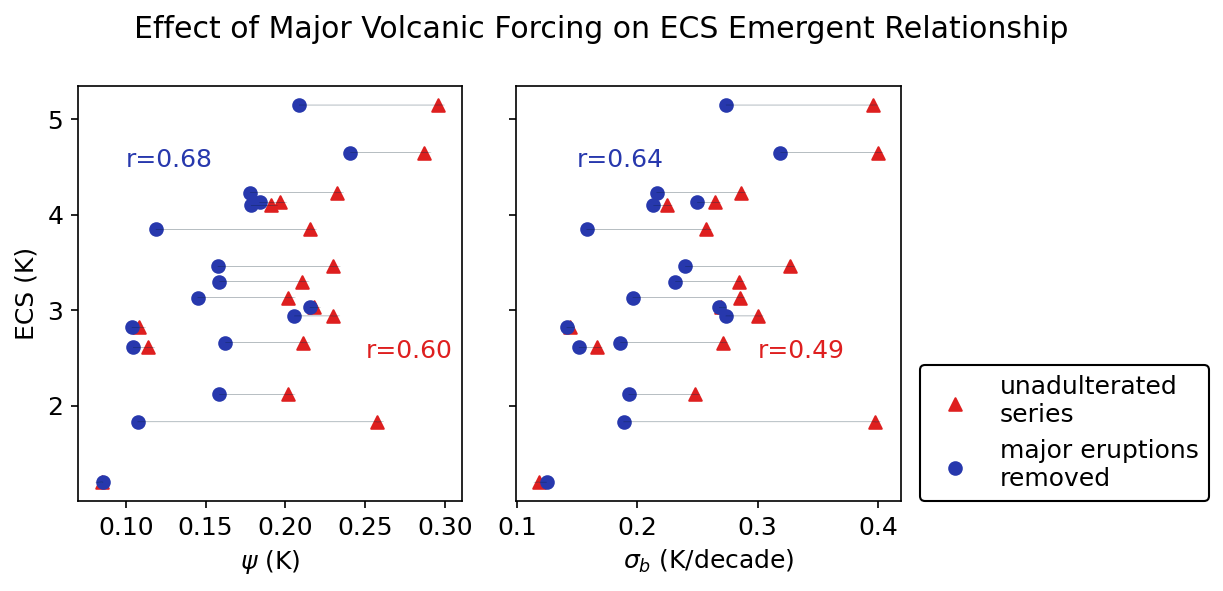

In [7]:
removed_color = '#2738ad'
volcano_color = '#de1f1f'

ec_data = pd.read_csv('data/ec_data.csv').drop('Unnamed: 0', axis=1)
fig, axs = plt.subplots(1, 2, figsize = (8.5, 4), sharey=True)
axs[0].scatter(ec_data['cox'], ec_data['ecs'], color = volcano_color, marker = '^')
axs[0].scatter(ec_data['rv_cox'], ec_data['ecs'], color = removed_color, marker = 'o')

for i in range(len(ec_data)):
    x_i = ec_data['rv_cox'][i]
    y_i = ec_data['ecs'][i]
    dx_i = x_i - ec_data['cox'][i]
    dy_i = 0
    axs[0].arrow(x_i, y_i, -1*dx_i, dy_i, linewidth = 0.05)

axs[0].text(0.1, 4.5, 'r=0.68', color = removed_color)
axs[0].text(0.25, 2.5, 'r=0.60', color = volcano_color)

axs[1].scatter(ec_data['nijsse'], ec_data['ecs'], color = volcano_color, marker = '^', label = 'unadulterated\nseries')
axs[1].scatter(ec_data['rv_nijsse'], ec_data['ecs'], color = removed_color, marker = 'o', label = 'major eruptions\nremoved')

for i in range(len(ec_data)):
    x_i = ec_data['rv_nijsse'][i]
    y_i = ec_data['ecs'][i]
    dx_i = x_i - ec_data['nijsse'][i]
    dy_i = 0
    axs[1].arrow(x_i, y_i, -1*dx_i, dy_i, linewidth = 0.05)

axs[1].text(0.15, 4.5, 'r=0.64', color = removed_color)
axs[1].text(0.3, 2.5, 'r=0.49', color = volcano_color)

slope, intercept, r, p, se = linregress(ec_data['rv_cox'], ec_data['ecs'])
print(r)
slope, intercept, r, p, se = linregress(ec_data['cox'], ec_data['ecs'])
print(r)
slope, intercept, r, p, se = linregress(ec_data['rv_nijsse'], ec_data['ecs'])
print(r)
slope, intercept, r, p, se = linregress(ec_data['nijsse'], ec_data['ecs'])
print(r)

fig.suptitle('Effect of Major Volcanic Forcing on ECS Emergent Relationship')

axs[1].legend(loc = (1.05, 0), edgecolor = 'black', framealpha = 1)

axs[0].set_ylabel('ECS (K)')
axs[0].set_xlabel(r'$\psi$ (K)')
axs[1].set_xlabel(r'$\sigma_{b}$ (K/decade)')

plt.tight_layout()
# plt.savefig('figures/figure_s1.png', dpi=3000)

# Supplemental Figure 4 (S4)

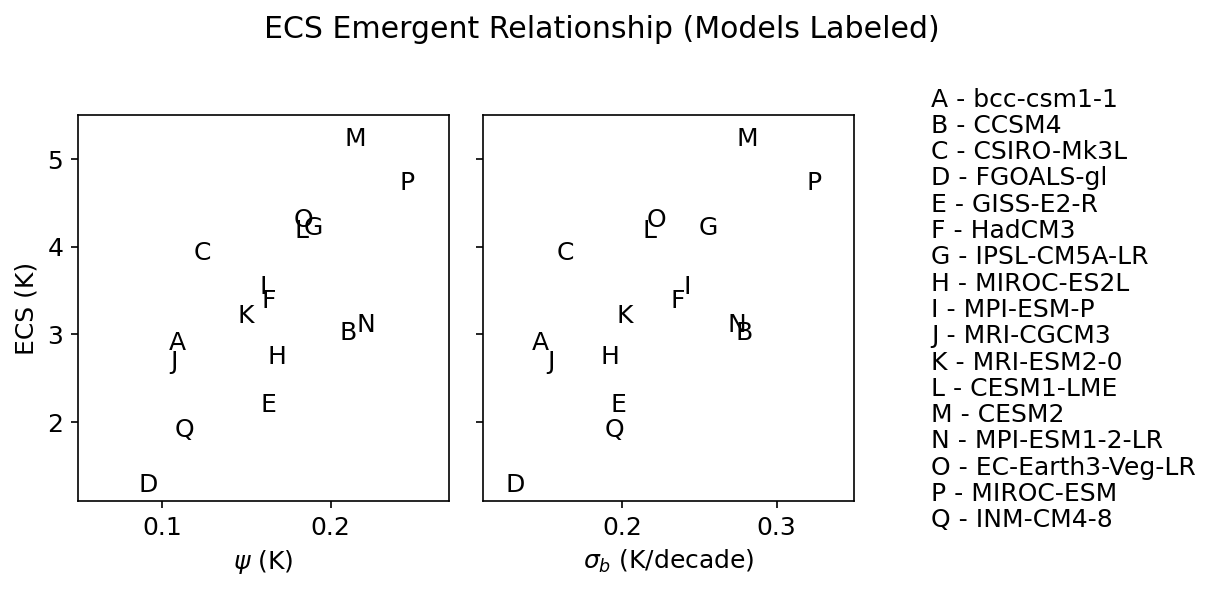

In [8]:
ec_data = pd.read_csv('data/ec_data.csv').drop('Unnamed: 0', axis=1)

# read in the timeseries dataframe
timeseries_df = pd.read_csv('data/ts.csv').drop('Unnamed: 0', axis=1)

# the columns of the dataframe are the model names
model_names = timeseries_df.columns[1:]

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8.5, 4))

fig.suptitle('ECS Emergent Relationship (Models Labeled)')
axs[0].set_ylabel('ECS (K)')
axs[0].set_xlabel(r'$\psi$ (K)')
axs[1].set_xlabel(r'$\sigma_{b}$ (K/decade)')
axs[0].set_xlim((0.05,0.27))
axs[0].set_ylim((1.1,5.5))
axs[1].set_ylim((1.1,5.5))
axs[1].set_xlim((0.11,0.35))

alphabet = ['A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H',
            'I', 'J', 'K', 'L',
            'M', 'N', 'O', 'P',
            'Q']

j = 5.6
for i in range(len(ec_data)):
    axs[0].text(ec_data['rv_cox'][i],
               ec_data['ecs'][i],
               alphabet[i])
    
    axs[1].text(ec_data['rv_nijsse'][i],
           ec_data['ecs'][i],
           alphabet[i])
    
    axs[1].text(0.4, j, alphabet[i] + ' - '+model_names[i])
    j -= 0.3

plt.tight_layout()
# plt.savefig('figures/figure_s4.png', dpi=3000)

# Supplemental Figure 3 (S3)

In [6]:
def get_forcing(saod):
    '''
    Takes in a timeseries of SAOD (numpy array) and outputs a forcing profile (in W/m^2)
    '''
    return np.multiply(-20.7, np.subtract(1, np.exp(np.multiply(-1, saod))))

# take a spatial average
def weighted_mean(da):
    
    # make 2d array of weights in case that lat is 1d
    if len(da.lat.shape)==2:
        weights=np.cos(np.deg2rad(da.lat))
    elif len(da.lat.shape)==1:
        weights = xr.ones_like(da)* (np.cos(np.deg2rad((da.lat))).values)
        
    # turn weights into nan where da is nan
    weights = weights*da/da
    
    if 'lat' in da.dims:
        wm = (da*weights).sum(dim=['lat'], skipna=True) / weights.sum(dim=['lat'], skipna=True)

    elif 'i' in da.dims:
        wm = (da*weights).sum(dim=['i','j'], skipna=True) / weights.sum(dim=['i','j'], skipna=True)
    elif 'nlat' in da.dims:
        wm = (da*weights).sum(dim=['nlat','nlon'], skipna=True) / weights.sum(dim=['nlat','nlon'], skipna=True)
    elif 'x' in da.dims:
        wm = (da*weights).sum(dim=['x','y'], skipna=True) / weights.sum(dim=['x','y'], skipna=True)
    return wm

def cox_metric(x):
    auto_m1 = tsa.acf(x,nlags=1) # autocorrelation function from statsmodels
    auto_m1b = np.abs(auto_m1[1])    # select 1 lag autocorrelation value
    sigma_m1= np.std(x, ddof=1) # take the sample standard deviation (fixed from previous code)
    log_m1= np.log(auto_m1b)   # compute the base-e logarithm
    log_m1b = np.abs(log_m1)   # take absolute value
    sqrt_m1 = np.sqrt(log_m1b) # take square root
    theta = sigma_m1/sqrt_m1 # compute theta
    return theta # return theta

def cox_mean(x):
    x=x[850:2000] # takes the years 850-1999
    cox_vals=np.zeros(int(len(x)/55)) # builds array to store the cox estimates
    i=0 # window counter
    j=0 # storage counter
    while i<len(x)-55: # while loop cycles through timeseries to build windows/cox estimates
        cox_vals[j]=(cox_metric(signal.detrend(x[i:i+55])))  # detrend, compute and store the Cox estimate
        i+=55 # increment window counter
        j+=1 # increment storage counter
    return np.mean(cox_vals) # return the mean Cox estimate across the timeseries

def compute_slopes(x, length=10):
    x = x[850:2000]
    # fill it with slopes
    slopes = []
    i = 0
    while i < len(x)-length:
        slope, intercept, r, p, se = linregress(np.arange(0,length), x[i:i+length])
        slopes.append(10*slope)
        i+=length
    return np.std(slopes)

evolv2k_ts = weighted_mean(xr.open_dataset('data/evolv2k.nc')).sel(time=slice(850,1850))
evolv2k_saod = []
i=850
while i <= 1850:
    evolv2k_saod.append(float(evolv2k_ts.sel(time=slice(i, i+1)).mean(dim='time').aod550.values))
    i+=1
evolv2k_forcing = get_forcing(evolv2k_saod)

def remove_volcano(x):
    ts = x
    ts_historical = x[1001:]
    ts_past1000 = x[:1001]
    X = evolv2k_forcing
    y = ts_past1000
    X = sm.add_constant(X)
    reg = sm.OLS(y, X).fit()
    return np.append(np.add(reg.resid, reg.params[0]), ts_historical)

In [ ]:
u_cox = []
u_sigma = []
s_cox = []
s_sigma = []

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/CPS.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(remove_volcano(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values))
    sigma_dataset[i]=compute_slopes(remove_volcano(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values))

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('CPS Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/PCR.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(remove_volcano(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values))
    sigma_dataset[i]=compute_slopes(remove_volcano(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values))

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('PCR Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/M08.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(remove_volcano(PAGES['GMST_anomaly_wrt_1961_1990_member'+str(i+1)+'_deg'].values))
    sigma_dataset[i]=compute_slopes(remove_volcano(PAGES['GMST_anomaly_wrt_1961_1990_member'+str(i+1)+'_deg'].values))

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('M08 Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/OIE.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(remove_volcano(PAGES['GMST_anomaly_wrt_1961_1990_member'+str(i+1)+'_deg'].values))
    sigma_dataset[i]=compute_slopes(remove_volcano(PAGES['GMST_anomaly_wrt_1961_1990_member'+str(i+1)+'_deg'].values))

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('OIE Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/BHM.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(remove_volcano(PAGES['E'+str(i+1)].values))
    sigma_dataset[i]=compute_slopes(remove_volcano(PAGES['E'+str(i+1)].values))

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('BHM Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/PAI.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(remove_volcano(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values))
    sigma_dataset[i]=compute_slopes(remove_volcano(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values))

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('PAI Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/DA.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(remove_volcano(PAGES['LME_member_'+str(i+1)+' (°C)'].values))
    sigma_dataset[i]=compute_slopes(remove_volcano(PAGES['LME_member_'+str(i+1)+' (°C)'].values))

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('DA Done')

In [ ]:
u_cox = []
u_sigma = []
s_cox = []
s_sigma = []

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/CPS.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values)
    sigma_dataset[i]=compute_slopes(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values)

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('CPS Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/PCR.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values)
    sigma_dataset[i]=compute_slopes(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values)

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('PCR Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/M08.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(PAGES['GMST_anomaly_wrt_1961_1990_member'+str(i+1)+'_deg'].values)
    sigma_dataset[i]=compute_slopes(PAGES['GMST_anomaly_wrt_1961_1990_member'+str(i+1)+'_deg'].values)

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('M08 Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/OIE.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(PAGES['GMST_anomaly_wrt_1961_1990_member'+str(i+1)+'_deg'].values)
    sigma_dataset[i]=compute_slopes(PAGES['GMST_anomaly_wrt_1961_1990_member'+str(i+1)+'_deg'].values)

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('OIE Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/BHM.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(PAGES['E'+str(i+1)].values)
    sigma_dataset[i]=compute_slopes(PAGES['E'+str(i+1)].values)

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('BHM Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/PAI.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values)
    sigma_dataset[i]=compute_slopes(PAGES['GMST_anomaly_wrt_1961_1990_member_'+str(i+1)+' (°C)'].values)

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('PAI Done')

# read in the reconstruction
PAGES=pd.read_csv('data/pages_2k/DA.txt',sep='\t',header=(0))

# loop through the ensemble members, compute mean Cox for each
cox_dataset=np.zeros(1000)
sigma_dataset=np.zeros(1000)
for i in range(1000):
    cox_dataset[i]=cox_mean(PAGES['LME_member_'+str(i+1)+' (°C)'].values)
    sigma_dataset[i]=compute_slopes(PAGES['LME_member_'+str(i+1)+' (°C)'].values)

# compute the estimate mean and standard deviation
u_cox.append(np.mean(cox_dataset))
s_cox.append(np.std(cox_dataset))

u_sigma.append(np.mean(sigma_dataset))
s_sigma.append(np.std(sigma_dataset))

print('DA Done')

In [ ]:
print(np.mean(u_cox), np.std(u_cox))
u_cox

In [ ]:
print(np.mean(u_sigma), np.std(u_sigma))
u_sigma

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (8.5, 4))
methods = ['CPS', 'PCR', 'M08', 'OIE', 'BHM', 'PAI', 'DA']
x = methods
axs[0].axhline(y=np.mean(u_cox), color='black')
axs[0].axhspan(np.mean(u_cox)-np.std(u_cox), np.mean(u_cox)+np.std(u_cox), color = 'grey', alpha = 0.1)
axs[0].errorbar(x, u_cox, yerr=np.std(u_cox), fmt='o', capsize=5)

axs[1].axhline(y=np.mean(u_sigma), color='black')
axs[1].axhspan(np.mean(u_sigma)-np.std(u_sigma), np.mean(u_sigma)+np.std(u_sigma), color = 'grey', alpha = 0.1)
axs[1].errorbar(x, u_sigma, yerr=np.std(u_sigma), fmt='o', capsize=5)


axs[0].set_ylabel(r'$\psi$ (K)')
axs[1].set_ylabel(r'$\sigma_{b}$ (K/decade)')
axs[0].set_xlabel('Methodology')
axs[1].set_xlabel('Methodology')

fig.suptitle('Temperature Variability Metrics according to PAGES 2k\nby Reconstruction Methodology')

plt.tight_layout()
plt.savefig('figures/figure_s3.png', dpi=3000)

# Supplemental Figure 2 (S2)

In [9]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from scipy.stats import linregress
import matplotlib as mpl
from statsmodels.api import tsa
import statsmodels.api as sm
import xarray as xr

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
# mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['font.size'] = 12

def get_forcing(saod):
    '''
    Takes in a timeseries of SAOD (numpy array) and outputs a forcing profile (in W/m^2)
    '''
    return np.multiply(-20.7, np.subtract(1, np.exp(np.multiply(-1, saod))))

def remove_volcano(timeseries, temp_anomaly):
    X = temp_anomaly # independent variable
    y = timeseries   # dependent variable

    # to get intercept -- this is optional
    X = sm.add_constant(X)

    # fit the regression model
    reg = sm.OLS(y, X).fit()
    
    return reg.resid.values

# take a spatial average
def weighted_mean(da):
    
    # make 2d array of weights in case that lat is 1d
    if len(da.lat.shape)==2:
        weights=np.cos(np.deg2rad(da.lat))
    elif len(da.lat.shape)==1:
        weights = xr.ones_like(da)* (np.cos(np.deg2rad((da.lat))).values)
        
    # turn weights into nan where da is nan
    weights = weights*da/da
    
    if 'lat' in da.dims:
        wm = (da*weights).sum(dim=['lat'], skipna=True) / weights.sum(dim=['lat'], skipna=True)

    elif 'i' in da.dims:
        wm = (da*weights).sum(dim=['i','j'], skipna=True) / weights.sum(dim=['i','j'], skipna=True)
    elif 'nlat' in da.dims:
        wm = (da*weights).sum(dim=['nlat','nlon'], skipna=True) / weights.sum(dim=['nlat','nlon'], skipna=True)
    elif 'x' in da.dims:
        wm = (da*weights).sum(dim=['x','y'], skipna=True) / weights.sum(dim=['x','y'], skipna=True)
    return wm

def compute_cox(x):
    x = x[~np.isnan(x)]
    psi_vals=[]
    for i in np.arange(0, len(x)-55):
        y = signal.detrend(x[i:i+55])
        auto_m1 = tsa.acf(y,nlags=1) # autocorrelation function from statsmodels
        auto_m1b = auto_m1[1]    # select 1 lag autocorrelation value
        sigma_m1= np.std(y)
        log_m1= np.log(auto_m1b)
        log_m1b = np.abs(log_m1)   # take absolute value
        sqrt_m1 = np.sqrt(log_m1b)
        psi = sigma_m1/sqrt_m1
        psi_vals.append(psi)
    return np.nanmean(psi_vals)

def compute_nijsse(x, length=10):
    # remove NaNs from the timeseries
    x = np.array(x)
    mask = ~np.isnan(x)
    x = x[mask]
    # fill it with slopes
    slopes = []
    i = 0
    while i < len(x)-length:
        slope, intercept, r, p, se = linregress(np.arange(0,length), x[i:i+length])
        slopes.append(length*slope)
        i+=length
    return np.nanstd(slopes)

In [10]:
evolv2k_ts = weighted_mean(xr.open_dataset('data/evolv2k.nc')).sel(time=slice(850,1850))
evolv2k_saod = []
i=850
while i <= 1850:
    evolv2k_saod.append(float(evolv2k_ts.sel(time=slice(i, i+1)).mean(dim='time').aod550.values))
    i+=1
evolv2k_forcing = get_forcing(evolv2k_saod)

gao_2008_saod = np.divide(pd.read_csv('data/gao_2008.csv')['gm'].values.astype(float), 1.2*10**3)
gao_2008_forcing = get_forcing(gao_2008_saod)
crowley_2000_forcing = pd.read_csv('data/crowley_2000.txt', delimiter = '\t')['Vol.hl.cct'].values

crowley_2008_saod = pd.read_csv('data/crowley_2008.txt', delimiter = '\t')['AOD'].values
crowley_2008_forcing = get_forcing(crowley_2008_saod)

In [53]:
df = pd.read_csv('data/ts.csv')
model_keys = df.keys()[2:]
forcings = ['gao', 'gao', 'crowley_08', 'crowley_00',
            'evolv2k', 'crowley_08', 'gao', 'evolv2k',
            'crowley_08', 'gao', 'evolv2k', 'gao', 
            'evolv2k', 'evolv2k', 'evolv2k', 'crowley_08',
            'evolv2k']
ecs_vals = []
original_cox = []
rv_cox = []
original_nijsse = []
rv_nijsse = []

t = pd.read_csv('data/ecs.csv')

for i in range(len(model_keys)):
    ts = df[model_keys[i]].values
    ts_past1000 = ts[:1001]
    if model_keys[i] == 'HadCM3':
        X = crowley_2008_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts_past1000))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts_past1000))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))
    elif forcings[i] == 'gao':
        X = gao_2008_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts_past1000))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts_past1000))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))
    elif forcings[i] == 'crowley_00':
        X = crowley_2000_forcing
        y = ts[151:]
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))
    elif forcings[i] == 'crowley_08':
        X = crowley_2008_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts_past1000))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts_past1000))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))
    elif forcings[i] == 'evolv2k':
        X = evolv2k_forcing
        y = ts_past1000
        X = sm.add_constant(X)
        reg = sm.OLS(y, X).fit()
        ecs_vals.append(t[t['model name']==model_keys[i]]['ecs'].values[0])
        original_cox.append(compute_cox(ts_past1000))
        rv_cox.append(compute_cox(np.add(reg.resid, reg.params[0])))
        original_nijsse.append(compute_nijsse(ts_past1000))
        rv_nijsse.append(compute_nijsse(np.add(reg.resid, reg.params[0])))

In [54]:
sigma_1850 = rv_nijsse
sigma_full = ec_data['rv_nijsse']

cox_1850 = rv_cox
cox_full = ec_data['rv_cox']

ecs = ec_data['ecs']

In [55]:
df = pd.read_csv('data/ts.csv')
model_keys = df.keys()[2:]

sigma_historical = []
cox_historical = []

t = pd.read_csv('data/ec_data.csv')

for i in range(len(model_keys)):
    ecs_vals.append(t[t['model']==model_keys[i]]['ecs'].values[0])
    ts = df[model_keys[i]].values
    ts_historical = ts[1000:]
    if t[t['model']==model_keys[i]]['generation'].values[0] == 'CMIP5':
        cox_historical.append(compute_cox(ts_historical))
        sigma_historical.append(compute_nijsse(ts_historical))
    if t[t['model']==model_keys[i]]['generation'].values[0] == 'CMIP6':
        cox_historical.append(compute_cox(ts_historical))
        sigma_historical.append(compute_nijsse(ts_historical))
    if t[t['model']==model_keys[i]]['generation'].values[0] == 'na':
        cox_historical.append(compute_cox(ts_historical))
        sigma_historical.append(compute_nijsse(ts_historical))

0.6327546184832694
0.3487863828943199
0.675707623208301
0.6384682100133737
0.4256161739799929
0.6438953991517491


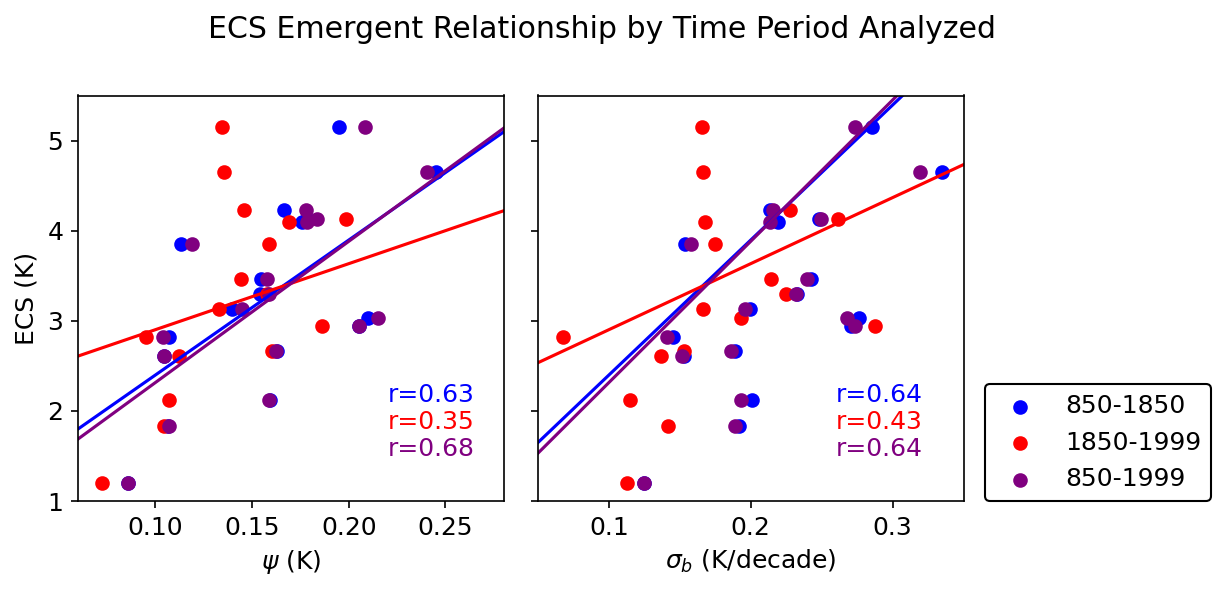

In [93]:
color_1850 = 'blue'
color_historical = 'red'
color_full = 'purple'


fig, axs = plt.subplots(1, 2, figsize = (8.5, 4), sharey=True)

axs[0].scatter(cox_1850, ecs, color = color_1850, marker = 'o', label = '850-1850')
slope, intercept, r, p, se = linregress(cox_1850, ecs)
x=np.linspace(0.05, 0.35, 100)
axs[0].plot(x,slope*x+intercept, color = color_1850)

axs[0].scatter(cox_historical, ecs, color = color_historical, marker = 'o', label = '1850-1999')
slope, intercept, r, p, se = linregress(cox_historical, ecs)
x=np.linspace(0.05, 0.35, 100)
axs[0].plot(x,slope*x+intercept, color = color_historical)

axs[0].scatter(cox_full, ecs, color = color_full, marker = 'o', label = '850-1999')
slope, intercept, r, p, se = linregress(cox_full, ecs)
x=np.linspace(0.05, 0.35, 100)
axs[0].plot(x,slope*x+intercept, color = color_full)

axs[0].set_xlim(0.06,0.28)
axs[0].set_ylim(1,5.5)

axs[1].scatter(sigma_1850, ecs, color = color_1850, marker = 'o', label = '850-1850')
slope, intercept, r, p, se = linregress(cox_1850, ecs)
x=np.linspace(0.05, 0.35, 100)
axs[1].plot(x,slope*x+intercept, color = color_1850)

axs[1].scatter(sigma_historical, ecs, color = 'red', marker = 'o', label = '1850-1999')
slope, intercept, r, p, se = linregress(cox_historical, ecs)
x=np.linspace(0.05, 0.35, 100)
axs[1].plot(x,slope*x+intercept, color = color_historical)

axs[1].scatter(sigma_full, ecs, color = color_full, marker = 'o', label = '850-1999')
slope, intercept, r, p, se = linregress(cox_full, ecs)
x=np.linspace(0.05, 0.35, 100)
axs[1].plot(x,slope*x+intercept, color = color_full)

axs[1].set_xlim(0.05, 0.35)
axs[1].set_ylim(1, 5.5)


axs[1].text(0.26, 1.5, 'r=0.64', color = color_full)
axs[1].text(0.26, 2.1, 'r=0.64', color = color_1850)
axs[1].text(0.26, 1.8, 'r=0.43', color = color_historical)

axs[0].text(0.22, 1.5, 'r=0.68', color = color_full)
axs[0].text(0.22, 2.1, 'r=0.63', color = color_1850)
axs[0].text(0.22, 1.8, 'r=0.35', color = color_historical)


slope, intercept, r, p, se = linregress(cox_1850, ecs)
print(r)
slope, intercept, r, p, se = linregress(cox_historical, ecs)
print(r)
slope, intercept, r, p, se = linregress(cox_full, ecs)
print(r)
slope, intercept, r, p, se = linregress(sigma_1850, ecs)
print(r)
slope, intercept, r, p, se = linregress(sigma_historical, ecs)
print(r)
slope, intercept, r, p, se = linregress(sigma_full, ecs)
print(r)

fig.suptitle('ECS Emergent Relationship by Time Period Analyzed')

axs[1].legend(loc = (1.05, 0), edgecolor = 'black', framealpha = 1)

axs[0].set_ylabel('ECS (K)')
axs[0].set_xlabel(r'$\psi$ (K)')
axs[1].set_xlabel(r'$\sigma_{b}$ (K/decade)')

plt.tight_layout()
plt.savefig('figures/figure_s2.png', dpi=3000)

In [34]:
df = pd.read_csv('data/ts.csv')
model_keys = df.keys()[2:]
forcings = ['gao', 'gao', 'crowley_08', 'crowley_00',
            'evolv2k', 'crowley_08', 'gao', 'evolv2k',
            'crowley_08', 'gao', 'evolv2k', 'gao', 
            'evolv2k', 'evolv2k', 'evolv2k', 'crowley_08',
            'evolv2k']

cmip5_ecs = []
cmip5_cox = []
cmip5_nijsse = []
cmip6_ecs = []
cmip6_cox = []
cmip6_nijsse = []
other_ecs = []
other_cox = []
other_nijsse = []


t = pd.read_csv('data/ec_data.csv')

for i in range(len(model_keys)):
    ecs_vals.append(t[t['model']==model_keys[i]]['ecs'].values[0])
    ts = df[model_keys[i]].values
    ts_historical = ts[1000:]
    print(t[t['model']==model_keys[i]]['generation'].values[0])
    if t[t['model']==model_keys[i]]['generation'].values[0] == 'CMIP5':
        cmip5_cox.append(compute_cox(ts_historical))
        cmip5_nijsse.append(compute_nijsse(ts_historical))
        cmip5_ecs.append(t[t['model']==model_keys[i]]['ecs'].values[0])
    if t[t['model']==model_keys[i]]['generation'].values[0] == 'CMIP6':
        cmip6_cox.append(compute_cox(ts_historical))
        cmip6_nijsse.append(compute_nijsse(ts_historical))
        cmip6_ecs.append(t[t['model']==model_keys[i]]['ecs'].values[0])
    if t[t['model']==model_keys[i]]['generation'].values[0] == 'na':
        other_cox.append(compute_cox(ts_historical))
        other_nijsse.append(compute_nijsse(ts_historical))
        other_ecs.append(t[t['model']==model_keys[i]]['ecs'].values[0])        

CMIP5
CMIP5
CMIP5
CMIP5
CMIP5
CMIP5
CMIP5
CMIP6
CMIP5
CMIP5
CMIP6
na
CMIP6
CMIP6
CMIP6
CMIP5
CMIP6


0.6908428713920417
-0.025083602542131055
0.6628417794951433
0.7024496911374755


Text(0.5, 0, 'Cox Metric (K)')

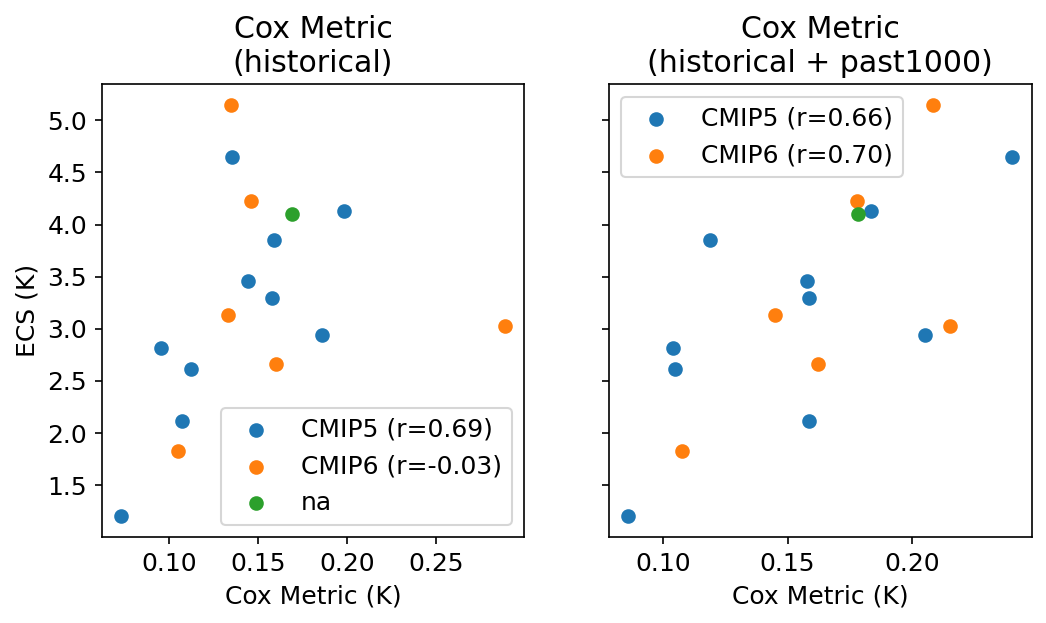

In [45]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4), sharey=True)

axs[0].scatter(cmip5_cox, cmip5_ecs, label='CMIP5 (r=0.69)')
slope, intercept, r, p, se = linregress(cmip5_cox, cmip5_ecs)
print(r)
axs[0].scatter(cmip6_cox, cmip6_ecs, label='CMIP6 (r=-0.03)')
slope, intercept, r, p, se = linregress(cmip6_cox, cmip6_ecs)
print(r)
axs[0].scatter(other_cox, other_ecs, label='na')

cmip5_mask = t['generation']=='CMIP5'
cmip6_mask = t['generation']=='CMIP6'
other_mask = t['generation']=='na'
axs[1].scatter(t['rv_cox'][cmip5_mask], t['ecs'][cmip5_mask], label='CMIP5 (r=0.66)')
slope, intercept, r, p, se = linregress(t['rv_cox'][cmip5_mask], t['ecs'][cmip5_mask])
print(r)
axs[1].scatter(t['rv_cox'][cmip6_mask], t['ecs'][cmip6_mask], label='CMIP6 (r=0.70)')
slope, intercept, r, p, se = linregress(t['rv_cox'][cmip6_mask], t['ecs'][cmip6_mask])
print(r)
axs[1].scatter(t['rv_cox'][other_mask], t['ecs'][other_mask])

axs[0].set_title('Cox Metric\n(historical)')
axs[1].set_title('Cox Metric\n(historical + past1000)')

axs[0].legend()
axs[1].legend()

axs[0].set_ylabel('ECS (K)')
axs[0].set_xlabel('Cox Metric (K)')
axs[1].set_xlabel('Cox Metric (K)')

In [48]:
linregress(np.append(np.append(cmip5_cox, cmip6_cox), other_cox), np.append(np.append(cmip5_ecs, cmip6_ecs), other_ecs))

LinregressResult(slope=7.32999489376467, intercept=2.168009104516213, rvalue=0.34878638289431996, pvalue=0.17003401779103677, stderr=5.085478755901102, intercept_stderr=0.7872280333497771)